In [1]:
import numpy as np

from utils import unnormalized_Laplacian
from sdp import SDP_relaxation
from mpec import MPEC_EPM

In [2]:
A = np.array([[0, 3, 2, 0, 0, 0],
              [3, 0, 4, 0, 0, 0],
              [2, 4, 0, 0, 0, 0],
              [0, 0, 0, 0, 4, 4],
              [0, 0, 0, 4, 0, 2],
              [0, 0, 0, 4, 2, 0]])

In [3]:
x_opt = SDP_relaxation(unnormalized_Laplacian(A), options={'maxiter': 10, 'disp': False})
np.dot(np.dot(x_opt, unnormalized_Laplacian(A)), x_opt)

28.0

In [4]:
x_opt

array([ 1., -1.,  1., -1., -1., -1.])

In [5]:
a = np.zeros((A.shape[0], ))
b = 0
l = -np.ones((A.shape[0], ))
l[0] = 1
u = np.ones((A.shape[0], ))
u[-1] = -1
x_opt = MPEC_EPM(unnormalized_Laplacian(A), a, b, l, u, options={'maxiter': 20})
np.dot(np.dot(x_opt, unnormalized_Laplacian(A)), x_opt)

8.88178419700126e-16

In [6]:
x_opt

array([ 1.,  1.,  1., -1., -1., -1.])

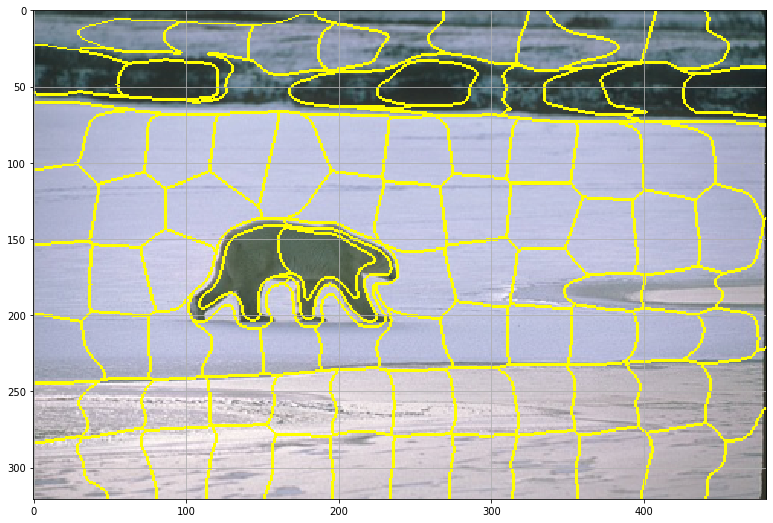

In [7]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

image = io.imread('data/100007.jpg')
image = img_as_float(image)


for numSegments in [100]:
    
    segments = slic(image, n_segments = numSegments, sigma = 5)
    fig = plt.figure(figsize = (17,9))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("on")

plt.grid()
plt.show()

In [8]:
def dist(x, y):
    return np.linalg.norm(x - y)

def Laplacian(X):
    n = X.shape[0]
    W = np.zeros((n, n))
    for i in range(0, n):
        for j in range(n):
            if j < i:
                W[i, j] = W[j, i]
            elif j > i:
                W[i, j] = dist(X[i, :], X[j, :])
                
    return np.diag(np.sum(W, axis=1)) - W

In [9]:
# !pip install python-polylabel

In [10]:
# from polylabel import polylabel

In [11]:
segments_ids = np.unique(segments)
X = np.zeros((len(segments_ids), 5))
for i in segments_ids:
    coordinates = np.array(np.nonzero(segments==i))
    
    polygon = [[x, y] for x, y in zip(coordinates[0], coordinates[1])]
    center = np.array(polygon[np.random.choice(len(polygon))])
    
    color = np.array(sum([image[x, y] for x, y in zip(coordinates[0], coordinates[1])]))/coordinates.shape[1]
    
    X[i, :] = np.hstack((color.reshape(1, -1), center.reshape(1, -1))).ravel()

In [12]:
L = Laplacian(X)

In [25]:
a = np.zeros((L.shape[0], ))
b = 0
l = -np.ones((L.shape[0], ))
l[46] = 1
u = np.ones((L.shape[0], ))
u[0] = -1
u[1] = -1
x_opt = MPEC_EPM(L, a, b, l, u, options={'maxiter': 20})
np.dot(np.dot(x_opt, L), x_opt)

48225.95359540952

# Visualize results

## MPEC

In [27]:
x_opt = MPEC_EPM(L, a, b, l, u, options={'maxiter': 20})

In [28]:
def RoundValue(value, threshold=0.5):
    if abs(value) > threshold:
        new_value = 1
    else:
        new_value = 0
    return np.sign(value) * new_value

In [29]:
def GetMask(segments, x_opt, threshold=0.5):
    segments_list = segments.ravel().tolist()
    segment_numbers = list({seg_num for seg_num in segments_list})
    mask = np.ones_like(segments)
    for idx, seg_num in enumerate(segment_numbers):
        fill_value = RoundValue(x_opt[idx], threshold)
        mask[segments == seg_num] = fill_value
    return mask

In [58]:
from skimage import color
def DrawMasked(image, mask, alpha=0.8):
    
    channel_mask = 255 * np.stack([np.zeros_like(mask), mask, np.zeros_like(mask)], axis=2)
    new_image = image.copy()

    image_hsv = color.rgb2hsv(new_image)
    mask_hsv = color.rgb2hsv(channel_mask)

#     image_hsv[..., 0] = mask_hsv[..., 0]
#     image_hsv[..., 1] = alpha * mask_hsv[..., 1]

    new_image = color.hsv2rgb(image_hsv)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,9))
    ax1.imshow(mark_boundaries(new_image, mask))
    ax2.imshow(channel_mask)

In [59]:
mask = GetMask(segments, x_opt, 0.6)
mask[mask != 1] = 0  # get 0/1 mask

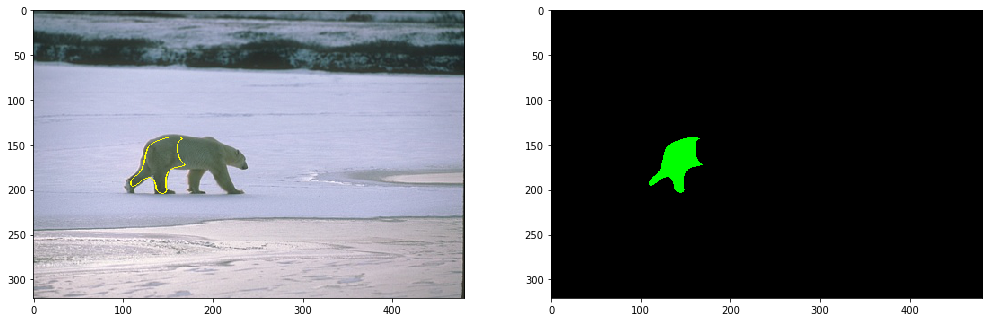

In [60]:
DrawMasked(image, mask)

## SDP

In [61]:
# x_opt = SDP_relaxation(L, l, u, options={'maxiter': 10, 'disp': True})
x_opt = SDP_relaxation(L, options={'maxiter': 10, 'disp': True})
np.dot(np.dot(x_opt, L), x_opt)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1825152.4553639207
            Iterations: 1
            Function evaluations: 95
            Gradient evaluations: 1


1825152.4553639204

In [62]:
mask = GetMask(segments, x_opt, 0.6)
mask[mask != 1] = 0  # get 0/1 mask

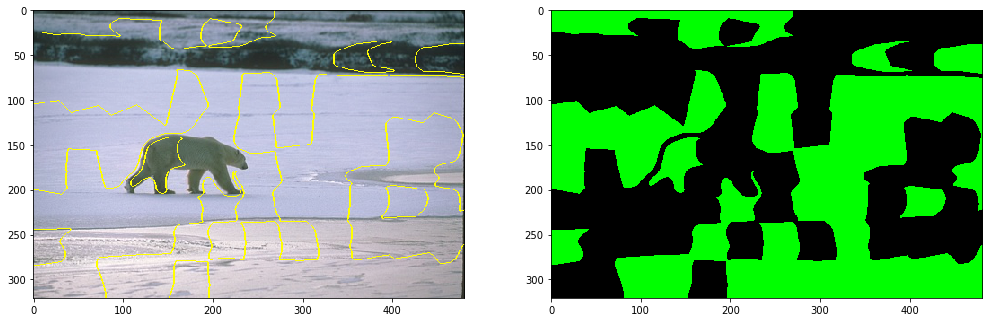

In [63]:
DrawMasked(image, mask)